## Neural Network and Convolutional Neural Network Practice

In step 5, we want to add two more type functions into our program. 

First is optimization function. 
Previously, we apply stochastic gradient decent method (SGD) to adjust the weights and bias (training models). SGD is widely used by almost all machine learning models, however, there are more methods we can try to increase the training time, and get better model in some cases. 

Second, weight decay and dropout are two popular regularization methods to prevent overfitting in neural network models.

In [1]:
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

### Optimization functions

In this section, we implement some most common used optimization functions (optimizers). And use a simple function to show optimization efficiency.

#### Stochastic gradient decent (SGD):

$ W_{t+1} = W_t-\eta \frac{\partial Error}{\partial W_t}$

where $W_t$ are weights in step $t$, $\eta$ is learning rate, $Error$ is model predicted error. SGD is very similar to Newtown's method for finding root of polynomial functions. Both methods are possible to find and stick with local minimum.

In [2]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

#### Momentum
$v_t = \alpha v_{t-1} - \eta \frac{\partial Error}{\partial W_t}$

$ W_{t+1} = W_t + v_t$

Where $v_t$ is the velocity, $\alpha$ is the fraction coefficient (in physical meaning). Momentum method incorporates the changing rate as velocity. From formula 1, we can observe the velocity was affected by all previous velocities. And the historical velocities decay rate order increased as iteration increased. 

In [3]:
class Momentum:
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr, self.momentum = lr, momentum
        self.vel = None
        
    def update(self, params, grads):
        if self.vel is None: 
            self.vel = {} 
            for key, value in params.items():
                self.vel[key] = np.zeros_like(value)
                # zeros_like: Return an array of zeros with the same shape and type as a given array.
        for key in params.keys():
            self.vel[key] = self.momentum * self.vel[key] - self.lr * grads[key]
            params[key] += self.vel[key]

#### AdaGrad (RMSprop was modified from AdaGrad)
$h_{t+1} = h_t + \frac{\partial Error}{\partial W_t} \odot \frac{\partial Error}{\partial W_t}$

$W_{t+1} = W - \eta \frac{1}{\sqrt{h}}\frac{\partial Error}{\partial W_t}$

Where $h$ is the sum of squre gradients, which stores the historical weight changing information. The weight update procedure will encounter historical changes. One drawback is that after numerous iterations (h increased), the weights will stop updating. 

In [4]:
class AdaGrad:
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros_like(value)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

#### Adam (combine momentum and adaGrad)

Adam method is combining both momentum and AdaGrad methods.

In [5]:
class Adam:
    def __init__(self, lr = 0.01, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1, self.beta2 = beta1, beta2
        self.iter = 0
        self.m, self.v = None, None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, value in params.items():
                self.m[key], self.v[key] = np.zeros_like(value), np.zeros_like(value)
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter) 
        
        for key in params.keys():
            self.m[key] += (1.0 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1.0 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

#### RMS prop

$W_t = W_{t-1}-\frac{\eta}{\sqrt{E[g^2]_t+\epsilon}}*\frac{\partial Error}{\partial W_t}$

$E[g^2]_t=0.9 E[g^2]_{t-1}+0.1g_t^2$

where $E[g^2]_t$ is exponential average of squares of gradients at time t.

ref: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

In [6]:
class RMSprop:
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr, self.decay_rate = lr, decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] *= self.decay_rate # E[g^2]_t-1
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key] # g_t^2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Visulization of the differences between each optimizer

Here we use simple function to test our optimizers. We also predefine the gradient functions. 

$f(x,y) = \frac{x^2}{20}+y^2$

$\frac{df}{dx} = \frac{2x}{20} = \frac{x}{10}$

$\frac{df}{dy} = 2y$

In [7]:
# simple function 
# the minimum of f is located at (x, y) = (0, 0)
def f(x, y):
    return x**2 / 20.0 + y**2
# gradient (differential equations)
def df(x, y):
    return x / 10.0, 2.0*y

In [8]:
# initial condition
init_x_y = (-9.0, 2.0)

# parameter and gradient dictionary
params = {}
grads = {}

In [9]:
def testCase():
    idx = 1
    fig = plt.figure(figsize = (15,15))
    for key in optimizers:
        optimizer = optimizers[key]
        x_log = []
        y_log = []
        params['x'], params['y'] = init_x_y[0], init_x_y[1]
    
        for i in range(30):
            x_log.append(params['x'])
            y_log.append(params['y'])

            grads['x'], grads['y'] = df(params['x'], params['y'])
            optimizer.update(params, grads)


        x = np.arange(-10, 10, 0.01)
        y = np.arange(-5, 5, 0.01)

        X, Y = np.meshgrid(x, y) 
        Z = f(X, Y)

        # for simple contour line  
        mask = Z > 7
        Z[mask] = 0

        # plot 
        plt.subplot(3, 2, idx)
        idx += 1
        plt.plot(x_log, y_log, 'o-', color="red")
        plt.contour(X, Y, Z)
        plt.ylim(-10, 10)
        plt.xlim(-10, 10)
        plt.plot(0, 0, '+')
        #colorbar()
        #spring()
        plt.title(key)
        plt.xlabel("x")
        plt.ylabel("y")

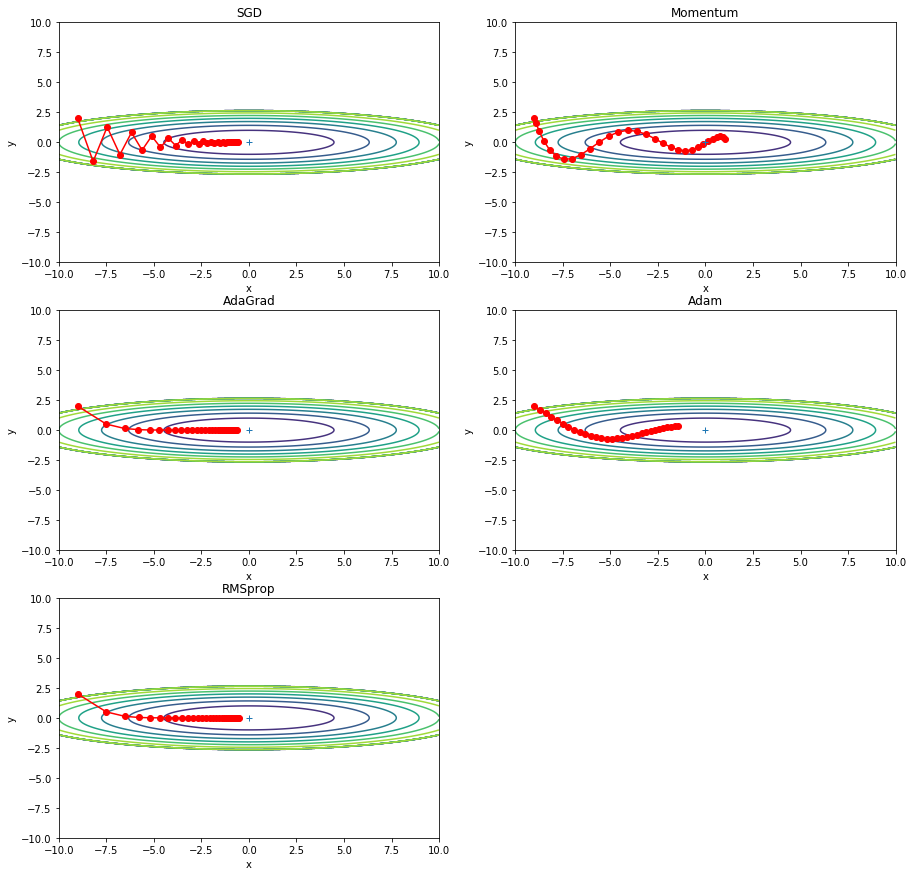

In [10]:
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.9)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)
optimizers["RMSprop"] = RMSprop(lr=0.15)
testCase()

The example is borrowed from the textbook. If the learning rate is too large when using SGD method, the oscillation phenomena will happen, which means the weights are not modified efficiently (detour from initial point to center). Momentum method slightly improves the oscillation issue and keeps the learning rate small enough. Adaptive gradient method (AdaGrad) applies learning rate decay idea to make the learning process from large step learning to small step learning. The position track looks perfect in this case. Note, the learning rate of AdaGrad will decrease to 0 with large enough iterations, weights will stop update in such case. RMSprop will fix this problem.  Adam is a combined method of Momentun and AdaGrad. The standard setting of $\beta_1$ and $\beta_2$ are 0.9 and 0.999.

Note, the learning rate is a hyper parameter we have to tune. There is no single best optimizer can solve all problems. Most researchers are still using SGD today, because in high dimensional problems, the overshooting problem is rarely happened, and singular point is also rare. SGD can still provide a good way to find the optimized solution.

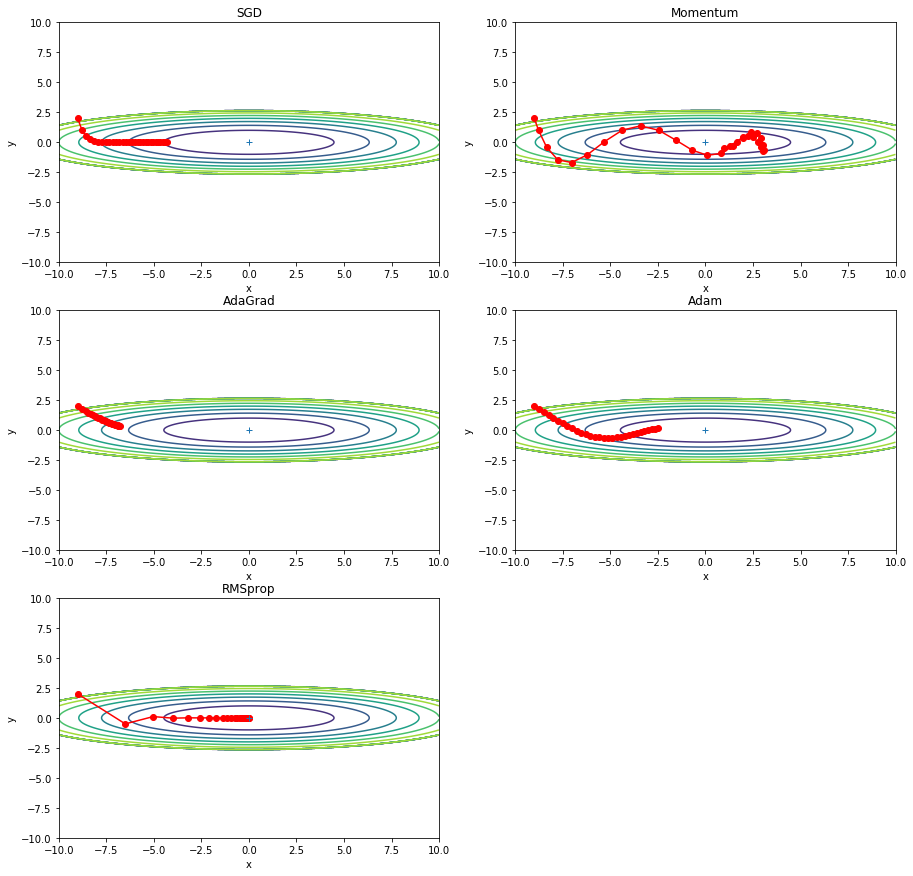

In [11]:
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.25)
optimizers["Momentum"] = Momentum(lr=0.25)
optimizers["AdaGrad"] = AdaGrad(lr=0.25)
optimizers["Adam"] = Adam(lr=0.25)
optimizers["RMSprop"] = RMSprop(lr=0.25)
testCase()